# HW3 Image Classification
## We strongly recommend that you run with [Kaggle](https://www.kaggle.com/t/86ca241732c04da99aca6490080bae73) for this homework

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2023-spring@googlegroups.com

# Check GPU Type

In [1]:
!nvidia-smi

Thu Jun 13 04:28:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.76                 Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0             19W /   80W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [2]:
# Download Link
# Link 1 (Dropbox): https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0
# Link 2 (Google Drive): https://drive.google.com/file/d/1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9/view?usp=share_link
# Link 3: Kaggle Competition.

# (1) dropbox link
#!wget -O food11.zip https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0

# (2) google drive link
#!pip install gdown --upgrade
#!gdown --id '1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9' --output food11.zip

In [3]:
#!unzip food11.zip

# Import Packages

In [4]:
_exp_name = "cnn"

In [5]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm.auto import tqdm
import random
# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
#plot
import matplotlib.pyplot as plt
# Pretrained model
from torchvision.models import resnet34, resnet18, vgg16, densenet121, alexnet, squeezenet1_0

In [6]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Transforms
Torchvision provides lots of useful utilities for image preprocessing, data *wrapping* as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [7]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    # You may add some transforms here.
    transforms.Resize((128, 128)),
    transforms.RandomRotation(40),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
    
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    
])

# Datasets
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [8]:
from pathlib import Path   # new for windows

class FoodDataset(Dataset):
    def __init__(self,path=None, tfm=test_tfm, files = None):
        super(FoodDataset).__init__()
        # self.path = path
        if path is not None:
            self.path = Path(path)
            # self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
            self.files = sorted([self.path.joinpath(child.name) for child in self.path.iterdir() if str(child).endswith(".jpg")])     # NEW: use the pathlib library
        else:
            self.files = files
        
        self.transform = tfm
        print(f'data length: {len(self.files)}')
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        # fname = self.files[idx]
        # im = Image.open(fname)
        # im = self.transform(im)
        
        # try:
        #     label = int(fname.split("\\")[-1].split("_")[0])
        # except:
        #     label = -1 # test has no label
        filepath = self.files[idx]
        with Image.open(filepath) as im:
            im = self.transform(im)
        
        try:
            label = int(Path(filepath).name.split("_")[0])
        except:
            label = -1 # test has no label
            
        return im,label

data length: 10000


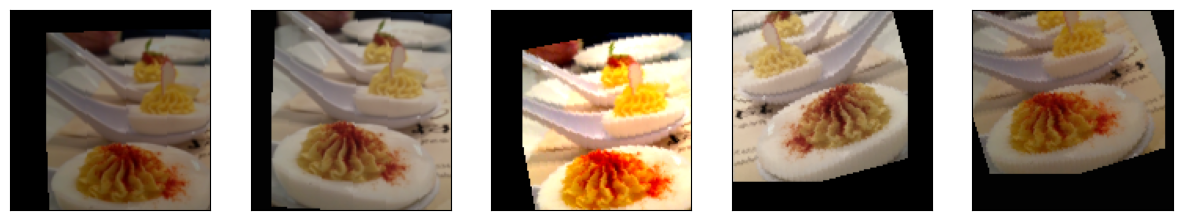

In [9]:
train_dataset = FoodDataset('./train/', tfm=train_tfm)
_, axes = plt.subplots(1, 5, figsize=(15, 50))
axes = axes.flatten()
for i in range(5):
    x,_ = train_dataset[2]
    x = x.permute(1,2,0)
    axes[i].imshow(x.data.numpy())
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)
plt.show()

# Model

In [12]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 224, 224]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)
     

# Configurations

In [13]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)

# The number of batch size.
batch_size = 256

# The number of training epochs.
n_epochs = 200

# If no improvement in 'patience' epochs, early stop.
patience = 20
k_fold = 4

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Create a learning rate scheduler that reduces the learning rate when the metric stops improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=patience/2, threshold=0.05)

In [12]:
device

'cuda'

# Dataloader

In [14]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_dir = './train/'
valid_dir = './valid/'
train_files = [ os.path.join(train_dir, file) for file in os.listdir(train_dir) if file.endswith('.jpg')]
valid_files = [ os.path.join(valid_dir, file) for file in os.listdir(valid_dir) if file.endswith('.jpg')]
total_files = train_files + valid_files
random.shuffle(total_files)
nums = len(total_files) // k_fold

#train_set = FoodDataset("./train", tfm=train_tfm)
#train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
#valid_set = FoodDataset("./valid", tfm=test_tfm)
#valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Start Training

Cross Validation

In [14]:
# Create a SummaryWriter object to write data to TensorBoard and the results are stored in ./runs folder
#writer = SummaryWriter()

In [15]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for i in range(k_fold):
    stale = 0
    best_acc = 0

    model = Classifier().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=2e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=1, eta_min=3e-5)
    criterion = nn.CrossEntropyLoss()
    print(f'FOLD {i+1}', '-'*50)

    valid_files = total_files[i*nums:(i+1)*nums]
    train_files = total_files[:i*nums] + total_files[(i+1)*nums:]
    
    train_set = FoodDataset(tfm=train_tfm, files=train_files)
    train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=0, pin_memory=True)

    valid_set = FoodDataset(tfm=test_tfm, files=valid_files)
    valid_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=0, pin_memory=True)

    for epoch in range(n_epochs):

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            #imgs = imgs.half()
            #print(imgs.shape,labels.shape)

            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(device))

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(device))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)
            
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # Print the information.
        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            #imgs = imgs.half()

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)
            #break

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Print the information.
        print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


        # update logs
        if valid_acc > best_acc:
            with open(f"./fold_{i+1}_{_exp_name}_log.txt","a") as f:
                f.write(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best\n")
        else:
            with open(f"./fold_{i+1}_{_exp_name}_log.txt","a") as f:
                f.write(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}\n")
        f.close()


        # save models
        if valid_acc > best_acc:
            print(f"Best model found at epoch {epoch+1}, saving model")
            torch.save(model.state_dict(), f"fold_{i+1}_{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
            best_acc = valid_acc
            stale = 0
        else:
            stale += 1
            if stale > patience:
                print(f"No improvment {patience} consecutive epochs, early stopping")
                break
                
        # Update learning rate based on the best_acc so far
        scheduler.step(best_acc)

FOLD 1 --------------------------------------------------
data length: 10233
data length: 3410


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 001/200 ] loss = 2.46295, acc = 0.15912


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 001/200 ] loss = 2.30653, acc = 0.18065
Best model found at epoch 1, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 002/200 ] loss = 2.20107, acc = 0.25838


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 002/200 ] loss = 2.06181, acc = 0.29933
Best model found at epoch 2, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 003/200 ] loss = 2.08941, acc = 0.28007


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 003/200 ] loss = 1.93961, acc = 0.33644
Best model found at epoch 3, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 004/200 ] loss = 2.02864, acc = 0.30824


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 004/200 ] loss = 2.14076, acc = 0.31524


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 005/200 ] loss = 1.93156, acc = 0.33736


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 005/200 ] loss = 2.35911, acc = 0.26121


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 006/200 ] loss = 1.84332, acc = 0.35979


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 006/200 ] loss = 1.79665, acc = 0.39611
Best model found at epoch 6, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 007/200 ] loss = 1.74527, acc = 0.40104


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 007/200 ] loss = 1.73489, acc = 0.39465


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 008/200 ] loss = 1.69225, acc = 0.41865


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 008/200 ] loss = 1.54221, acc = 0.46446
Best model found at epoch 8, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 009/200 ] loss = 1.64883, acc = 0.43975


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 009/200 ] loss = 1.55651, acc = 0.46666
Best model found at epoch 9, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 010/200 ] loss = 1.59742, acc = 0.45153


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 010/200 ] loss = 1.56599, acc = 0.46614


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 011/200 ] loss = 1.51122, acc = 0.48105


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 011/200 ] loss = 1.72074, acc = 0.45055


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 012/200 ] loss = 1.51416, acc = 0.48386


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 012/200 ] loss = 1.45753, acc = 0.52444
Best model found at epoch 12, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 013/200 ] loss = 1.44981, acc = 0.50376


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 013/200 ] loss = 1.39972, acc = 0.52329


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 014/200 ] loss = 1.43428, acc = 0.50698


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 014/200 ] loss = 1.23742, acc = 0.58143
Best model found at epoch 14, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 015/200 ] loss = 1.37603, acc = 0.52338


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 015/200 ] loss = 1.35356, acc = 0.55158


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 016/200 ] loss = 1.34024, acc = 0.53983


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 016/200 ] loss = 1.45993, acc = 0.50698


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 017/200 ] loss = 1.28027, acc = 0.56081


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 017/200 ] loss = 1.32082, acc = 0.55576


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 018/200 ] loss = 1.25928, acc = 0.57246


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 018/200 ] loss = 1.35853, acc = 0.55371


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 019/200 ] loss = 1.25237, acc = 0.57437


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 019/200 ] loss = 1.39443, acc = 0.55995


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 020/200 ] loss = 1.21705, acc = 0.58553


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 020/200 ] loss = 1.23736, acc = 0.58520
Best model found at epoch 20, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 021/200 ] loss = 1.15581, acc = 0.60196


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 021/200 ] loss = 1.24695, acc = 0.57257


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 022/200 ] loss = 1.14842, acc = 0.60334


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 022/200 ] loss = 1.13001, acc = 0.61495
Best model found at epoch 22, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 023/200 ] loss = 1.11468, acc = 0.61733


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 023/200 ] loss = 1.06805, acc = 0.64465
Best model found at epoch 23, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 024/200 ] loss = 1.09449, acc = 0.63060


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 024/200 ] loss = 1.68253, acc = 0.50356


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 025/200 ] loss = 1.08348, acc = 0.62736


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 025/200 ] loss = 1.32653, acc = 0.56337


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 026/200 ] loss = 1.05914, acc = 0.64040


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 026/200 ] loss = 1.34735, acc = 0.58837


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 027/200 ] loss = 1.01722, acc = 0.65239


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 027/200 ] loss = 0.99675, acc = 0.67235
Best model found at epoch 27, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 028/200 ] loss = 0.99376, acc = 0.65809


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 028/200 ] loss = 1.30510, acc = 0.59162


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 029/200 ] loss = 0.99881, acc = 0.66362


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 029/200 ] loss = 1.03333, acc = 0.65351


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 030/200 ] loss = 0.96906, acc = 0.67075


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 030/200 ] loss = 1.51183, acc = 0.54175


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 031/200 ] loss = 0.93985, acc = 0.68168


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 031/200 ] loss = 1.22188, acc = 0.59542


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 032/200 ] loss = 0.96635, acc = 0.66737


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 032/200 ] loss = 1.23127, acc = 0.60717


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 033/200 ] loss = 0.93024, acc = 0.68318


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 033/200 ] loss = 1.02494, acc = 0.65411


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 034/200 ] loss = 0.92340, acc = 0.68706


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 034/200 ] loss = 1.19477, acc = 0.60891


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 035/200 ] loss = 0.93559, acc = 0.68173


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 035/200 ] loss = 1.11872, acc = 0.65188


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 036/200 ] loss = 0.89537, acc = 0.69638


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 036/200 ] loss = 1.05445, acc = 0.66649


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 037/200 ] loss = 0.88431, acc = 0.69911


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 037/200 ] loss = 0.91089, acc = 0.68951
Best model found at epoch 37, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 038/200 ] loss = 0.88372, acc = 0.69871


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 038/200 ] loss = 0.94139, acc = 0.70583
Best model found at epoch 38, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 039/200 ] loss = 0.86572, acc = 0.71060


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 039/200 ] loss = 0.98049, acc = 0.68476


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 040/200 ] loss = 0.83925, acc = 0.71855


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 040/200 ] loss = 1.18146, acc = 0.64420


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 041/200 ] loss = 0.84431, acc = 0.71349


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 041/200 ] loss = 0.98795, acc = 0.69139


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 042/200 ] loss = 0.82016, acc = 0.71788


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 042/200 ] loss = 0.89422, acc = 0.71193
Best model found at epoch 42, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 043/200 ] loss = 0.78248, acc = 0.73328


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 043/200 ] loss = 1.13883, acc = 0.65561


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 044/200 ] loss = 0.80237, acc = 0.72708


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 044/200 ] loss = 1.02846, acc = 0.67542


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 045/200 ] loss = 0.79334, acc = 0.73027


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 045/200 ] loss = 0.86325, acc = 0.71584
Best model found at epoch 45, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 046/200 ] loss = 0.79212, acc = 0.73430


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 046/200 ] loss = 0.90838, acc = 0.71085


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 047/200 ] loss = 0.74746, acc = 0.74309


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 047/200 ] loss = 1.11081, acc = 0.66600


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 048/200 ] loss = 0.75376, acc = 0.74573


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 048/200 ] loss = 1.15789, acc = 0.65655


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 049/200 ] loss = 0.75110, acc = 0.74231


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 049/200 ] loss = 0.87888, acc = 0.72850
Best model found at epoch 49, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 050/200 ] loss = 0.71781, acc = 0.75710


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 050/200 ] loss = 0.87841, acc = 0.72215


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 051/200 ] loss = 0.71997, acc = 0.75833


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 051/200 ] loss = 0.95567, acc = 0.69614


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 052/200 ] loss = 0.73522, acc = 0.75046


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 052/200 ] loss = 0.94909, acc = 0.70398


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 053/200 ] loss = 0.68439, acc = 0.76574


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 053/200 ] loss = 0.85493, acc = 0.73090
Best model found at epoch 53, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 054/200 ] loss = 0.68023, acc = 0.76842


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 054/200 ] loss = 0.94215, acc = 0.70973


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 055/200 ] loss = 0.67716, acc = 0.77229


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 055/200 ] loss = 0.89419, acc = 0.72368


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 056/200 ] loss = 0.67218, acc = 0.77379


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 056/200 ] loss = 0.91522, acc = 0.71155


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 057/200 ] loss = 0.66126, acc = 0.78010


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 057/200 ] loss = 0.85458, acc = 0.72484


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 058/200 ] loss = 0.65476, acc = 0.77865


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 058/200 ] loss = 0.86789, acc = 0.73471
Best model found at epoch 58, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 059/200 ] loss = 0.65241, acc = 0.77590


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 059/200 ] loss = 0.95546, acc = 0.71029


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 060/200 ] loss = 0.65655, acc = 0.77730


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 060/200 ] loss = 0.78188, acc = 0.75295
Best model found at epoch 60, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 061/200 ] loss = 0.63047, acc = 0.78980


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 061/200 ] loss = 0.82455, acc = 0.73248


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 062/200 ] loss = 0.60512, acc = 0.79342


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 062/200 ] loss = 0.81915, acc = 0.74405


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 063/200 ] loss = 0.59343, acc = 0.80135


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 063/200 ] loss = 0.91860, acc = 0.72592


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 064/200 ] loss = 0.60081, acc = 0.79534


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 064/200 ] loss = 0.87073, acc = 0.73010


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 065/200 ] loss = 0.61092, acc = 0.79218


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 065/200 ] loss = 1.03856, acc = 0.69209


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 066/200 ] loss = 0.59347, acc = 0.79866


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 066/200 ] loss = 0.82339, acc = 0.73474


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 067/200 ] loss = 0.58247, acc = 0.80386


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 067/200 ] loss = 0.85416, acc = 0.73921


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 068/200 ] loss = 0.55144, acc = 0.81461


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 068/200 ] loss = 0.89672, acc = 0.73655


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 069/200 ] loss = 0.55963, acc = 0.80702


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 069/200 ] loss = 0.83802, acc = 0.74458


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 070/200 ] loss = 0.56366, acc = 0.80417


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 070/200 ] loss = 0.84946, acc = 0.74196


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 071/200 ] loss = 0.54840, acc = 0.81600


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 071/200 ] loss = 0.84491, acc = 0.73746


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 072/200 ] loss = 0.54652, acc = 0.81430


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 072/200 ] loss = 1.03689, acc = 0.70743


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 073/200 ] loss = 0.52470, acc = 0.82310


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 073/200 ] loss = 0.90972, acc = 0.73415


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 074/200 ] loss = 0.50291, acc = 0.83414


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 074/200 ] loss = 0.80270, acc = 0.75682
Best model found at epoch 74, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 075/200 ] loss = 0.51868, acc = 0.82713


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 075/200 ] loss = 0.91400, acc = 0.71720


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 076/200 ] loss = 0.51907, acc = 0.82320


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 076/200 ] loss = 0.79259, acc = 0.76083
Best model found at epoch 76, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 077/200 ] loss = 0.49263, acc = 0.83434


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 077/200 ] loss = 0.80372, acc = 0.76439
Best model found at epoch 77, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 078/200 ] loss = 0.50168, acc = 0.83023


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 078/200 ] loss = 0.75519, acc = 0.77164
Best model found at epoch 78, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 079/200 ] loss = 0.49852, acc = 0.83144


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 079/200 ] loss = 0.84763, acc = 0.75127


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 080/200 ] loss = 0.47497, acc = 0.83815


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 080/200 ] loss = 0.96779, acc = 0.72096


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 081/200 ] loss = 0.47741, acc = 0.83584


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 081/200 ] loss = 0.86869, acc = 0.74200


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 082/200 ] loss = 0.45762, acc = 0.84395


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 082/200 ] loss = 0.92753, acc = 0.74963


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 083/200 ] loss = 0.46298, acc = 0.84314


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 083/200 ] loss = 0.83177, acc = 0.76383


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 084/200 ] loss = 0.47875, acc = 0.83886


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 084/200 ] loss = 0.82219, acc = 0.76142


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 085/200 ] loss = 0.45081, acc = 0.84991


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 085/200 ] loss = 0.98864, acc = 0.72752


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 086/200 ] loss = 0.44828, acc = 0.84606


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 086/200 ] loss = 0.93473, acc = 0.74576


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 087/200 ] loss = 0.45528, acc = 0.84635


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 087/200 ] loss = 0.87603, acc = 0.75096


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 088/200 ] loss = 0.44488, acc = 0.85176


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 088/200 ] loss = 0.80932, acc = 0.76982


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 089/200 ] loss = 0.43840, acc = 0.85501


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 089/200 ] loss = 0.81903, acc = 0.76160


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 090/200 ] loss = 0.42354, acc = 0.85423


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 090/200 ] loss = 0.77654, acc = 0.77237
Best model found at epoch 90, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 091/200 ] loss = 0.42154, acc = 0.85216


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 091/200 ] loss = 0.82440, acc = 0.75769


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 092/200 ] loss = 0.42194, acc = 0.85966


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 092/200 ] loss = 0.82329, acc = 0.76815


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 093/200 ] loss = 0.41951, acc = 0.85468


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 093/200 ] loss = 0.73768, acc = 0.78646
Best model found at epoch 93, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 094/200 ] loss = 0.38643, acc = 0.86457


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 094/200 ] loss = 0.88876, acc = 0.75915


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 095/200 ] loss = 0.39192, acc = 0.86934


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 095/200 ] loss = 0.99026, acc = 0.75546


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 096/200 ] loss = 0.40478, acc = 0.86103


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 096/200 ] loss = 0.87058, acc = 0.75538


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 097/200 ] loss = 0.38309, acc = 0.86663


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 097/200 ] loss = 0.79278, acc = 0.76582


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 098/200 ] loss = 0.38198, acc = 0.86960


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 098/200 ] loss = 0.76372, acc = 0.78786
Best model found at epoch 98, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 099/200 ] loss = 0.36812, acc = 0.87776


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 099/200 ] loss = 0.96921, acc = 0.74939


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 100/200 ] loss = 0.37344, acc = 0.87015


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 100/200 ] loss = 0.87662, acc = 0.77167


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 101/200 ] loss = 0.38555, acc = 0.86851


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 101/200 ] loss = 0.83454, acc = 0.76484


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 102/200 ] loss = 0.36873, acc = 0.87314


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 102/200 ] loss = 1.06111, acc = 0.72756


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 103/200 ] loss = 0.36059, acc = 0.88048


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 103/200 ] loss = 0.98959, acc = 0.75793


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 104/200 ] loss = 0.35469, acc = 0.88048


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 104/200 ] loss = 1.06167, acc = 0.73781


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 105/200 ] loss = 0.35591, acc = 0.87561


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 105/200 ] loss = 0.99466, acc = 0.73921


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 106/200 ] loss = 0.34940, acc = 0.88450


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 106/200 ] loss = 0.87434, acc = 0.76686


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 107/200 ] loss = 0.34562, acc = 0.88479


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 107/200 ] loss = 0.97255, acc = 0.76086


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 108/200 ] loss = 0.34206, acc = 0.88272


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 108/200 ] loss = 0.96878, acc = 0.76373


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 109/200 ] loss = 0.32910, acc = 0.88723


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 109/200 ] loss = 0.84925, acc = 0.77778


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 110/200 ] loss = 0.31899, acc = 0.89623


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 110/200 ] loss = 1.22483, acc = 0.73192


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 111/200 ] loss = 0.34202, acc = 0.88643


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 111/200 ] loss = 1.40475, acc = 0.70771


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 112/200 ] loss = 0.34022, acc = 0.88577


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 112/200 ] loss = 0.88871, acc = 0.76303


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 113/200 ] loss = 0.32749, acc = 0.89031


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 113/200 ] loss = 0.75324, acc = 0.79438
Best model found at epoch 113, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 114/200 ] loss = 0.31037, acc = 0.89525


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 114/200 ] loss = 1.01693, acc = 0.75507


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 115/200 ] loss = 0.29682, acc = 0.89837


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 115/200 ] loss = 0.81774, acc = 0.79298


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 116/200 ] loss = 0.31522, acc = 0.89329


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 116/200 ] loss = 1.79994, acc = 0.63197


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 117/200 ] loss = 0.29226, acc = 0.90158


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 117/200 ] loss = 0.79482, acc = 0.79162


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 118/200 ] loss = 0.27964, acc = 0.90561


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 118/200 ] loss = 0.96176, acc = 0.77230


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 119/200 ] loss = 0.28882, acc = 0.90414


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 119/200 ] loss = 0.81134, acc = 0.79521
Best model found at epoch 119, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 120/200 ] loss = 0.30451, acc = 0.89514


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 120/200 ] loss = 0.90691, acc = 0.77422


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 121/200 ] loss = 0.31060, acc = 0.89406


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 121/200 ] loss = 1.00879, acc = 0.77000


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 122/200 ] loss = 0.28019, acc = 0.90286


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 122/200 ] loss = 0.94336, acc = 0.78169


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 123/200 ] loss = 0.27073, acc = 0.90606


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 123/200 ] loss = 0.96866, acc = 0.76603


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 124/200 ] loss = 0.27694, acc = 0.90754


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 124/200 ] loss = 0.87041, acc = 0.78524


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 125/200 ] loss = 0.27662, acc = 0.90482


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 125/200 ] loss = 1.20268, acc = 0.74559


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 126/200 ] loss = 0.27213, acc = 0.90561


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 126/200 ] loss = 0.88338, acc = 0.77478


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 127/200 ] loss = 0.25828, acc = 0.91118


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 127/200 ] loss = 1.03844, acc = 0.76850


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 128/200 ] loss = 0.27383, acc = 0.90842


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 128/200 ] loss = 1.19383, acc = 0.72501


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 129/200 ] loss = 0.26933, acc = 0.90805


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 129/200 ] loss = 1.34010, acc = 0.71606


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 130/200 ] loss = 0.25989, acc = 0.91126


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 130/200 ] loss = 1.19940, acc = 0.73876


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 131/200 ] loss = 0.25600, acc = 0.91169


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 131/200 ] loss = 0.96512, acc = 0.76616


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 132/200 ] loss = 0.25188, acc = 0.91496


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 132/200 ] loss = 0.79345, acc = 0.80470
Best model found at epoch 132, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 133/200 ] loss = 0.24555, acc = 0.91812


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 133/200 ] loss = 0.87550, acc = 0.78217


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 134/200 ] loss = 0.25942, acc = 0.91204


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 134/200 ] loss = 1.29029, acc = 0.71486


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 135/200 ] loss = 0.24205, acc = 0.91957


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 135/200 ] loss = 1.20389, acc = 0.74747


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 136/200 ] loss = 0.23875, acc = 0.91841


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 136/200 ] loss = 1.06139, acc = 0.75692


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 137/200 ] loss = 0.23206, acc = 0.92104


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 137/200 ] loss = 1.12745, acc = 0.75176


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 138/200 ] loss = 0.22356, acc = 0.92594


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 138/200 ] loss = 0.96587, acc = 0.78092


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 139/200 ] loss = 0.21912, acc = 0.92495


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 139/200 ] loss = 1.00587, acc = 0.77391


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 140/200 ] loss = 0.23732, acc = 0.92055


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 140/200 ] loss = 1.00137, acc = 0.76735


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 141/200 ] loss = 0.23385, acc = 0.92376


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 141/200 ] loss = 1.28570, acc = 0.73502


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 142/200 ] loss = 0.23320, acc = 0.91733


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 142/200 ] loss = 1.12762, acc = 0.74653


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 143/200 ] loss = 0.21388, acc = 0.92591


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 143/200 ] loss = 0.90020, acc = 0.78262


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 144/200 ] loss = 0.23242, acc = 0.92064


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 144/200 ] loss = 0.99291, acc = 0.77611


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 145/200 ] loss = 0.22816, acc = 0.92161


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 145/200 ] loss = 0.93250, acc = 0.79410


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 146/200 ] loss = 0.21813, acc = 0.92741


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 146/200 ] loss = 1.23217, acc = 0.73942


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 147/200 ] loss = 0.20610, acc = 0.93024


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 147/200 ] loss = 1.01627, acc = 0.77778


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 148/200 ] loss = 0.20743, acc = 0.92815


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 148/200 ] loss = 1.00328, acc = 0.78684


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 149/200 ] loss = 0.20926, acc = 0.92895


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 149/200 ] loss = 0.79922, acc = 0.80920
Best model found at epoch 149, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 150/200 ] loss = 0.19690, acc = 0.92992


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 150/200 ] loss = 1.08894, acc = 0.76721


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 151/200 ] loss = 0.19724, acc = 0.93305


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 151/200 ] loss = 1.03362, acc = 0.77101


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 152/200 ] loss = 0.20569, acc = 0.93120


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 152/200 ] loss = 0.98758, acc = 0.78880


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 153/200 ] loss = 0.20214, acc = 0.93190


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 153/200 ] loss = 1.38307, acc = 0.73279


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 154/200 ] loss = 0.19605, acc = 0.93313


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 154/200 ] loss = 1.03880, acc = 0.77185


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 155/200 ] loss = 0.19102, acc = 0.93637


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 155/200 ] loss = 1.09138, acc = 0.75909


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 156/200 ] loss = 0.20577, acc = 0.93111


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 156/200 ] loss = 1.14745, acc = 0.76062


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 157/200 ] loss = 0.19991, acc = 0.93120


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 157/200 ] loss = 0.97206, acc = 0.78681


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 158/200 ] loss = 0.18983, acc = 0.93666


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 158/200 ] loss = 1.09272, acc = 0.78220


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 159/200 ] loss = 0.19015, acc = 0.93507


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 159/200 ] loss = 1.17825, acc = 0.77304


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 160/200 ] loss = 0.17678, acc = 0.93884


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 160/200 ] loss = 0.96517, acc = 0.78817


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 161/200 ] loss = 0.17686, acc = 0.93902


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 161/200 ] loss = 1.09502, acc = 0.77255


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 162/200 ] loss = 0.17659, acc = 0.93962


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 162/200 ] loss = 1.03651, acc = 0.78768


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 163/200 ] loss = 0.18657, acc = 0.93668


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 163/200 ] loss = 1.00350, acc = 0.78311


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 164/200 ] loss = 0.18884, acc = 0.93822


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 164/200 ] loss = 1.05275, acc = 0.77865


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 165/200 ] loss = 0.17591, acc = 0.93885


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 165/200 ] loss = 0.95346, acc = 0.79752


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 166/200 ] loss = 0.16340, acc = 0.94429


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 166/200 ] loss = 1.05379, acc = 0.78535


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 167/200 ] loss = 0.15685, acc = 0.94517


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 167/200 ] loss = 1.06540, acc = 0.78709


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 168/200 ] loss = 0.17585, acc = 0.94264


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 168/200 ] loss = 1.05582, acc = 0.78067


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 169/200 ] loss = 0.17033, acc = 0.94348


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 169/200 ] loss = 1.26534, acc = 0.77645


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 170/200 ] loss = 0.17218, acc = 0.94176


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 170/200 ] loss = 1.03254, acc = 0.76836
No improvment 20 consecutive epochs, early stopping
FOLD 2 --------------------------------------------------
data length: 10233
data length: 3410


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 001/200 ] loss = 2.48568, acc = 0.13861


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 001/200 ] loss = 2.30095, acc = 0.18875
Best model found at epoch 1, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 002/200 ] loss = 2.24428, acc = 0.22860


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 002/200 ] loss = 2.04907, acc = 0.30463
Best model found at epoch 2, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 003/200 ] loss = 2.13645, acc = 0.26815


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 003/200 ] loss = 1.95164, acc = 0.32661
Best model found at epoch 3, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 004/200 ] loss = 2.05189, acc = 0.29032


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 004/200 ] loss = 1.87195, acc = 0.37058
Best model found at epoch 4, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 005/200 ] loss = 1.95065, acc = 0.32749


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 005/200 ] loss = 2.04441, acc = 0.32674


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 006/200 ] loss = 1.88785, acc = 0.34949


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 006/200 ] loss = 1.73953, acc = 0.40598
Best model found at epoch 6, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 007/200 ] loss = 1.81525, acc = 0.37198


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 007/200 ] loss = 1.70752, acc = 0.42021
Best model found at epoch 7, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 008/200 ] loss = 1.74807, acc = 0.39401


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 008/200 ] loss = 1.70053, acc = 0.43210
Best model found at epoch 8, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 009/200 ] loss = 1.71484, acc = 0.40528


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 009/200 ] loss = 1.51468, acc = 0.48301
Best model found at epoch 9, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 010/200 ] loss = 1.64130, acc = 0.43203


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 010/200 ] loss = 1.64547, acc = 0.44040


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 011/200 ] loss = 1.58406, acc = 0.45285


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 011/200 ] loss = 1.55961, acc = 0.46279


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 012/200 ] loss = 1.54621, acc = 0.47307


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 012/200 ] loss = 1.55415, acc = 0.47796


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 013/200 ] loss = 1.50009, acc = 0.48743


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 013/200 ] loss = 1.44638, acc = 0.49846
Best model found at epoch 13, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 014/200 ] loss = 1.46701, acc = 0.49947


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 014/200 ] loss = 1.43281, acc = 0.51880
Best model found at epoch 14, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 015/200 ] loss = 1.40146, acc = 0.52446


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 015/200 ] loss = 1.42902, acc = 0.52891
Best model found at epoch 15, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 016/200 ] loss = 1.38210, acc = 0.52655


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 016/200 ] loss = 1.39591, acc = 0.53317
Best model found at epoch 16, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 017/200 ] loss = 1.35482, acc = 0.53150


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 017/200 ] loss = 1.45454, acc = 0.51538


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 018/200 ] loss = 1.33602, acc = 0.54518


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 018/200 ] loss = 1.35148, acc = 0.55531
Best model found at epoch 18, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 019/200 ] loss = 1.27080, acc = 0.56345


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 019/200 ] loss = 1.37923, acc = 0.52654


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 020/200 ] loss = 1.24456, acc = 0.57806


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 020/200 ] loss = 1.19999, acc = 0.59277
Best model found at epoch 20, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 021/200 ] loss = 1.20882, acc = 0.58914


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 021/200 ] loss = 1.26319, acc = 0.58897


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 022/200 ] loss = 1.20006, acc = 0.59212


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 022/200 ] loss = 1.32618, acc = 0.57056


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 023/200 ] loss = 1.20239, acc = 0.58936


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 023/200 ] loss = 1.15781, acc = 0.59870
Best model found at epoch 23, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 024/200 ] loss = 1.15265, acc = 0.60785


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 024/200 ] loss = 1.22065, acc = 0.56344


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 025/200 ] loss = 1.13907, acc = 0.61053


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 025/200 ] loss = 1.21135, acc = 0.59274


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 026/200 ] loss = 1.10120, acc = 0.62358


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 026/200 ] loss = 1.25395, acc = 0.58317


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 027/200 ] loss = 1.07941, acc = 0.63398


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 027/200 ] loss = 1.14414, acc = 0.61638
Best model found at epoch 27, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 028/200 ] loss = 1.04135, acc = 0.64666


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 028/200 ] loss = 1.25872, acc = 0.60658


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 029/200 ] loss = 1.03183, acc = 0.64594


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 029/200 ] loss = 1.10825, acc = 0.62960
Best model found at epoch 29, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 030/200 ] loss = 1.01145, acc = 0.65610


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 030/200 ] loss = 1.23760, acc = 0.60361


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 031/200 ] loss = 0.99329, acc = 0.66393


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 031/200 ] loss = 1.02572, acc = 0.65868
Best model found at epoch 31, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 032/200 ] loss = 1.00092, acc = 0.66538


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 032/200 ] loss = 1.72014, acc = 0.50896


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 033/200 ] loss = 0.98703, acc = 0.66608


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 033/200 ] loss = 1.09497, acc = 0.64225


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 034/200 ] loss = 0.94846, acc = 0.67842


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 034/200 ] loss = 1.07161, acc = 0.64860


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 035/200 ] loss = 0.93134, acc = 0.67878


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 035/200 ] loss = 1.07369, acc = 0.64714


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 036/200 ] loss = 0.94847, acc = 0.68014


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 036/200 ] loss = 0.98105, acc = 0.66733
Best model found at epoch 36, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 037/200 ] loss = 0.89919, acc = 0.69509


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 037/200 ] loss = 1.28272, acc = 0.60620


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 038/200 ] loss = 0.90771, acc = 0.69431


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 038/200 ] loss = 1.00133, acc = 0.65826


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 039/200 ] loss = 0.88160, acc = 0.69999


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 039/200 ] loss = 0.95775, acc = 0.68076
Best model found at epoch 39, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 040/200 ] loss = 0.87030, acc = 0.70936


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 040/200 ] loss = 1.00529, acc = 0.67797


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 041/200 ] loss = 0.86417, acc = 0.70887


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 041/200 ] loss = 0.95798, acc = 0.67671


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 042/200 ] loss = 0.84992, acc = 0.71104


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 042/200 ] loss = 0.99639, acc = 0.67849


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 043/200 ] loss = 0.81456, acc = 0.72863


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 043/200 ] loss = 0.98131, acc = 0.69209
Best model found at epoch 43, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 044/200 ] loss = 0.80480, acc = 0.72450


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 044/200 ] loss = 1.06026, acc = 0.68711


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 045/200 ] loss = 0.80202, acc = 0.72754


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 045/200 ] loss = 1.06907, acc = 0.66733


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 046/200 ] loss = 0.79379, acc = 0.72715


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 046/200 ] loss = 0.93336, acc = 0.70325
Best model found at epoch 46, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 047/200 ] loss = 0.78786, acc = 0.73368


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 047/200 ] loss = 0.91825, acc = 0.70656
Best model found at epoch 47, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 048/200 ] loss = 0.76895, acc = 0.73881


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 048/200 ] loss = 0.89471, acc = 0.72208
Best model found at epoch 48, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 049/200 ] loss = 0.77933, acc = 0.73748


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 049/200 ] loss = 1.09745, acc = 0.65464


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 050/200 ] loss = 0.74420, acc = 0.74535


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 050/200 ] loss = 1.22773, acc = 0.61913


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 051/200 ] loss = 0.75073, acc = 0.74512


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 051/200 ] loss = 1.04126, acc = 0.68675


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 052/200 ] loss = 0.72421, acc = 0.75541


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 052/200 ] loss = 1.10814, acc = 0.67145


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 053/200 ] loss = 0.70824, acc = 0.75822


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 053/200 ] loss = 0.92544, acc = 0.72166


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 054/200 ] loss = 0.71141, acc = 0.76500


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 054/200 ] loss = 1.61937, acc = 0.63217


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 055/200 ] loss = 0.69552, acc = 0.77004


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 055/200 ] loss = 0.89370, acc = 0.72076


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 056/200 ] loss = 0.69455, acc = 0.76504


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 056/200 ] loss = 1.15409, acc = 0.65889


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 057/200 ] loss = 0.68568, acc = 0.76404


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 057/200 ] loss = 0.97553, acc = 0.70025


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 058/200 ] loss = 0.67351, acc = 0.77306


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 058/200 ] loss = 1.05822, acc = 0.68902


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 059/200 ] loss = 0.63652, acc = 0.78683


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 059/200 ] loss = 0.95685, acc = 0.70594


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 060/200 ] loss = 0.64403, acc = 0.78327


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 060/200 ] loss = 1.02359, acc = 0.70304


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 061/200 ] loss = 0.65585, acc = 0.78024


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 061/200 ] loss = 0.98068, acc = 0.71110


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 062/200 ] loss = 0.62612, acc = 0.78833


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 062/200 ] loss = 0.96278, acc = 0.70217


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 063/200 ] loss = 0.63338, acc = 0.78413


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 063/200 ] loss = 0.83836, acc = 0.74360
Best model found at epoch 63, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 064/200 ] loss = 0.63206, acc = 0.78902


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 064/200 ] loss = 1.15434, acc = 0.68037


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 065/200 ] loss = 0.62560, acc = 0.78490


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 065/200 ] loss = 1.10139, acc = 0.67856


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 066/200 ] loss = 0.59800, acc = 0.79557


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 066/200 ] loss = 0.77153, acc = 0.76083
Best model found at epoch 66, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 067/200 ] loss = 0.58811, acc = 0.80409


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 067/200 ] loss = 0.94233, acc = 0.72752


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 068/200 ] loss = 0.57520, acc = 0.80523


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 068/200 ] loss = 0.79120, acc = 0.76114
Best model found at epoch 68, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 069/200 ] loss = 0.58091, acc = 0.80133


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 069/200 ] loss = 1.09651, acc = 0.70643


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 070/200 ] loss = 0.58398, acc = 0.80157


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 070/200 ] loss = 1.07526, acc = 0.70342


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 071/200 ] loss = 0.57333, acc = 0.80727


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 071/200 ] loss = 0.81870, acc = 0.75421


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 072/200 ] loss = 0.54773, acc = 0.81665


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 072/200 ] loss = 1.18244, acc = 0.69592


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 073/200 ] loss = 0.56168, acc = 0.80944


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 073/200 ] loss = 0.89456, acc = 0.73293


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 074/200 ] loss = 0.55246, acc = 0.81199


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 074/200 ] loss = 1.09097, acc = 0.70943


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 075/200 ] loss = 0.53262, acc = 0.81992


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 075/200 ] loss = 1.00937, acc = 0.71508


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 076/200 ] loss = 0.52616, acc = 0.82089


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 076/200 ] loss = 1.11876, acc = 0.70140


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 077/200 ] loss = 0.52844, acc = 0.82126


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 077/200 ] loss = 0.97436, acc = 0.72724


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 078/200 ] loss = 0.51215, acc = 0.82935


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 078/200 ] loss = 0.77870, acc = 0.76100


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 079/200 ] loss = 0.52668, acc = 0.81951


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 079/200 ] loss = 1.40802, acc = 0.65662


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 080/200 ] loss = 0.52178, acc = 0.82381


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 080/200 ] loss = 1.03876, acc = 0.69994


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 081/200 ] loss = 0.50581, acc = 0.82900


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 081/200 ] loss = 0.82529, acc = 0.75598


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 082/200 ] loss = 0.47059, acc = 0.84218


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 082/200 ] loss = 0.88393, acc = 0.75065


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 083/200 ] loss = 0.47405, acc = 0.83806


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 083/200 ] loss = 1.09835, acc = 0.72268


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 084/200 ] loss = 0.47651, acc = 0.83868


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 084/200 ] loss = 1.19079, acc = 0.69886


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 085/200 ] loss = 0.48038, acc = 0.83588


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 085/200 ] loss = 0.79167, acc = 0.75790


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 086/200 ] loss = 0.45954, acc = 0.84510


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 086/200 ] loss = 0.85121, acc = 0.75696


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 087/200 ] loss = 0.46421, acc = 0.84168


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 087/200 ] loss = 0.95861, acc = 0.74528


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 088/200 ] loss = 0.44509, acc = 0.84863


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 088/200 ] loss = 0.88304, acc = 0.75919


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 089/200 ] loss = 0.44782, acc = 0.84931


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 089/200 ] loss = 0.94170, acc = 0.75050
No improvment 20 consecutive epochs, early stopping
FOLD 3 --------------------------------------------------
data length: 10233
data length: 3410


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 001/200 ] loss = 2.46087, acc = 0.16045


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 001/200 ] loss = 2.23779, acc = 0.22909
Best model found at epoch 1, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 002/200 ] loss = 2.22738, acc = 0.24650


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 002/200 ] loss = 2.10404, acc = 0.29842
Best model found at epoch 2, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 003/200 ] loss = 2.11853, acc = 0.28361


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 003/200 ] loss = 2.14194, acc = 0.29898
Best model found at epoch 3, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 004/200 ] loss = 2.03873, acc = 0.30850


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 004/200 ] loss = 1.95297, acc = 0.30742
Best model found at epoch 4, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 005/200 ] loss = 1.95559, acc = 0.32443


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 005/200 ] loss = 1.84336, acc = 0.39091
Best model found at epoch 5, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 006/200 ] loss = 1.86531, acc = 0.36498


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 006/200 ] loss = 2.03213, acc = 0.35541


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 007/200 ] loss = 1.78335, acc = 0.39326


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 007/200 ] loss = 1.68198, acc = 0.41954
Best model found at epoch 7, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 008/200 ] loss = 1.72282, acc = 0.40665


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 008/200 ] loss = 2.06030, acc = 0.36870


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 009/200 ] loss = 1.64466, acc = 0.43605


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 009/200 ] loss = 1.65576, acc = 0.43294
Best model found at epoch 9, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 010/200 ] loss = 1.63006, acc = 0.44408


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 010/200 ] loss = 1.57212, acc = 0.46725
Best model found at epoch 10, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 011/200 ] loss = 1.55250, acc = 0.46965


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 011/200 ] loss = 1.54745, acc = 0.46467


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 012/200 ] loss = 1.50399, acc = 0.48394


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 012/200 ] loss = 2.01186, acc = 0.39792


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 013/200 ] loss = 1.47420, acc = 0.49527


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 013/200 ] loss = 1.50270, acc = 0.49069
Best model found at epoch 13, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 014/200 ] loss = 1.44115, acc = 0.50817


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 014/200 ] loss = 1.68180, acc = 0.46896


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 015/200 ] loss = 1.38358, acc = 0.52882


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 015/200 ] loss = 1.34873, acc = 0.53505
Best model found at epoch 15, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 016/200 ] loss = 1.33831, acc = 0.54336


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 016/200 ] loss = 1.33656, acc = 0.53816
Best model found at epoch 16, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 017/200 ] loss = 1.28459, acc = 0.55891


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 017/200 ] loss = 1.11625, acc = 0.60494
Best model found at epoch 17, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 018/200 ] loss = 1.25304, acc = 0.56476


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 018/200 ] loss = 1.41012, acc = 0.53697


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 019/200 ] loss = 1.25880, acc = 0.57490


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 019/200 ] loss = 1.25567, acc = 0.58775


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 020/200 ] loss = 1.19670, acc = 0.58899


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 020/200 ] loss = 1.70807, acc = 0.50446


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 021/200 ] loss = 1.17578, acc = 0.59879


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 021/200 ] loss = 1.19397, acc = 0.59863


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 022/200 ] loss = 1.15432, acc = 0.60764


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 022/200 ] loss = 1.29500, acc = 0.57948


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 023/200 ] loss = 1.13035, acc = 0.61419


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 023/200 ] loss = 1.15083, acc = 0.61836
Best model found at epoch 23, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 024/200 ] loss = 1.09528, acc = 0.62680


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 024/200 ] loss = 1.12738, acc = 0.62436
Best model found at epoch 24, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 025/200 ] loss = 1.08091, acc = 0.63363


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 025/200 ] loss = 1.30567, acc = 0.57767


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 026/200 ] loss = 1.06746, acc = 0.63568


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 026/200 ] loss = 1.17568, acc = 0.60857


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 027/200 ] loss = 1.04247, acc = 0.64568


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 027/200 ] loss = 1.26131, acc = 0.60288


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 028/200 ] loss = 1.02554, acc = 0.64588


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 028/200 ] loss = 1.08507, acc = 0.63612
Best model found at epoch 28, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 029/200 ] loss = 1.01882, acc = 0.65710


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 029/200 ] loss = 1.04519, acc = 0.65603
Best model found at epoch 29, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 030/200 ] loss = 0.98110, acc = 0.66715


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 030/200 ] loss = 1.12192, acc = 0.62701


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 031/200 ] loss = 0.97717, acc = 0.66910


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 031/200 ] loss = 1.00742, acc = 0.66053
Best model found at epoch 31, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 032/200 ] loss = 0.95580, acc = 0.67810


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 032/200 ] loss = 1.12379, acc = 0.62942


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 033/200 ] loss = 0.94586, acc = 0.67918


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 033/200 ] loss = 1.16040, acc = 0.62956


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 034/200 ] loss = 0.94273, acc = 0.68054


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 034/200 ] loss = 1.14658, acc = 0.63824


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 035/200 ] loss = 0.91982, acc = 0.68621


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 035/200 ] loss = 1.06471, acc = 0.66255
Best model found at epoch 35, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 036/200 ] loss = 0.90702, acc = 0.69289


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 036/200 ] loss = 0.95281, acc = 0.67905
Best model found at epoch 36, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 037/200 ] loss = 0.90654, acc = 0.69528


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 037/200 ] loss = 1.01990, acc = 0.66524


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 038/200 ] loss = 0.87699, acc = 0.70318


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 038/200 ] loss = 0.92396, acc = 0.68860
Best model found at epoch 38, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 039/200 ] loss = 0.85048, acc = 0.71015


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 039/200 ] loss = 0.90574, acc = 0.69495
Best model found at epoch 39, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 040/200 ] loss = 0.84119, acc = 0.71608


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 040/200 ] loss = 0.93392, acc = 0.69484


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 041/200 ] loss = 0.83077, acc = 0.71836


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 041/200 ] loss = 1.17842, acc = 0.64895


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 042/200 ] loss = 0.80930, acc = 0.72470


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 042/200 ] loss = 0.94577, acc = 0.69017


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 043/200 ] loss = 0.80762, acc = 0.72932


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 043/200 ] loss = 1.07641, acc = 0.66050


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 044/200 ] loss = 0.80026, acc = 0.73034


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 044/200 ] loss = 0.92439, acc = 0.70001
Best model found at epoch 44, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 045/200 ] loss = 0.79773, acc = 0.73147


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 045/200 ] loss = 1.03026, acc = 0.68156


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 046/200 ] loss = 0.76678, acc = 0.73964


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 046/200 ] loss = 1.12053, acc = 0.66095


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 047/200 ] loss = 0.76829, acc = 0.74142


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 047/200 ] loss = 1.00311, acc = 0.69004


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 048/200 ] loss = 0.76279, acc = 0.74497


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 048/200 ] loss = 1.07986, acc = 0.67096


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 049/200 ] loss = 0.74492, acc = 0.74806


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 049/200 ] loss = 0.95865, acc = 0.70925
Best model found at epoch 49, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 050/200 ] loss = 0.73152, acc = 0.75163


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 050/200 ] loss = 1.10731, acc = 0.66074


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 051/200 ] loss = 0.72920, acc = 0.74708


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 051/200 ] loss = 1.09167, acc = 0.67326


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 052/200 ] loss = 0.71533, acc = 0.75697


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 052/200 ] loss = 1.14076, acc = 0.64947


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 053/200 ] loss = 0.70553, acc = 0.75840


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 053/200 ] loss = 0.97608, acc = 0.69237


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 054/200 ] loss = 0.70285, acc = 0.76097


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 054/200 ] loss = 1.26811, acc = 0.64236


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 055/200 ] loss = 0.68497, acc = 0.77042


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 055/200 ] loss = 1.08645, acc = 0.68404


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 056/200 ] loss = 0.68988, acc = 0.76487


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 056/200 ] loss = 0.85240, acc = 0.72236
Best model found at epoch 56, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 057/200 ] loss = 0.67891, acc = 0.76956


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 057/200 ] loss = 0.87447, acc = 0.72602
Best model found at epoch 57, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 058/200 ] loss = 0.66398, acc = 0.77089


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 058/200 ] loss = 0.96973, acc = 0.70451


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 059/200 ] loss = 0.66903, acc = 0.77613


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 059/200 ] loss = 0.98692, acc = 0.70291


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 060/200 ] loss = 0.64402, acc = 0.77869


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 060/200 ] loss = 0.95084, acc = 0.71012


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 061/200 ] loss = 0.64614, acc = 0.78336


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 061/200 ] loss = 1.18720, acc = 0.63284


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 062/200 ] loss = 0.63520, acc = 0.78599


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 062/200 ] loss = 0.76210, acc = 0.75745
Best model found at epoch 62, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 063/200 ] loss = 0.62066, acc = 0.78912


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 063/200 ] loss = 1.11188, acc = 0.70307


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 064/200 ] loss = 0.60980, acc = 0.79260


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 064/200 ] loss = 1.04368, acc = 0.70088


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 065/200 ] loss = 0.59432, acc = 0.80066


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 065/200 ] loss = 0.88383, acc = 0.71616


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 066/200 ] loss = 0.60757, acc = 0.79369


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 066/200 ] loss = 0.86713, acc = 0.73711


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 067/200 ] loss = 0.60442, acc = 0.79313


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 067/200 ] loss = 1.04464, acc = 0.69111


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 068/200 ] loss = 0.58699, acc = 0.80328


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 068/200 ] loss = 1.02862, acc = 0.70608


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 069/200 ] loss = 0.58916, acc = 0.80507


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 069/200 ] loss = 1.06741, acc = 0.68320


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 070/200 ] loss = 0.58445, acc = 0.80212


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 070/200 ] loss = 0.86440, acc = 0.72142


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 071/200 ] loss = 0.55789, acc = 0.81170


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 071/200 ] loss = 0.96749, acc = 0.70765


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 072/200 ] loss = 0.53991, acc = 0.81459


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 072/200 ] loss = 1.00583, acc = 0.71832


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 073/200 ] loss = 0.55050, acc = 0.81313


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 073/200 ] loss = 0.88231, acc = 0.73418


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 074/200 ] loss = 0.54693, acc = 0.81101


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 074/200 ] loss = 0.99838, acc = 0.71224


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 075/200 ] loss = 0.52372, acc = 0.81949


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 075/200 ] loss = 1.07375, acc = 0.70053


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 076/200 ] loss = 0.52472, acc = 0.82012


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 076/200 ] loss = 1.19370, acc = 0.68752


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 077/200 ] loss = 0.52920, acc = 0.81967


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 077/200 ] loss = 1.32825, acc = 0.65356


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 078/200 ] loss = 0.51373, acc = 0.82236


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 078/200 ] loss = 0.92382, acc = 0.71989


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 079/200 ] loss = 0.50098, acc = 0.83007


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 079/200 ] loss = 0.96247, acc = 0.73537


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 080/200 ] loss = 0.48884, acc = 0.83368


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 080/200 ] loss = 0.97419, acc = 0.72857


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 081/200 ] loss = 0.49756, acc = 0.83065


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 081/200 ] loss = 1.00610, acc = 0.71968


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 082/200 ] loss = 0.48224, acc = 0.83846


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 082/200 ] loss = 1.02583, acc = 0.72208


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 083/200 ] loss = 0.45749, acc = 0.84425


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 083/200 ] loss = 0.97046, acc = 0.73527
No improvment 20 consecutive epochs, early stopping
FOLD 4 --------------------------------------------------
data length: 10233
data length: 3410


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 001/200 ] loss = 2.47473, acc = 0.14593


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 001/200 ] loss = 2.34079, acc = 0.17560
Best model found at epoch 1, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 002/200 ] loss = 2.22171, acc = 0.24091


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 002/200 ] loss = 2.27457, acc = 0.25176
Best model found at epoch 2, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 003/200 ] loss = 2.11593, acc = 0.27626


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 003/200 ] loss = 2.47980, acc = 0.25497
Best model found at epoch 3, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 004/200 ] loss = 2.05434, acc = 0.29297


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 004/200 ] loss = 1.83786, acc = 0.35363
Best model found at epoch 4, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 005/200 ] loss = 1.95640, acc = 0.32240


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 005/200 ] loss = 1.88252, acc = 0.35573
Best model found at epoch 5, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 006/200 ] loss = 1.89554, acc = 0.34670


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 006/200 ] loss = 1.71749, acc = 0.39757
Best model found at epoch 6, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 007/200 ] loss = 1.82495, acc = 0.36677


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 007/200 ] loss = 1.87040, acc = 0.37679


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 008/200 ] loss = 1.76124, acc = 0.38171


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 008/200 ] loss = 1.75268, acc = 0.38331


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 009/200 ] loss = 1.72048, acc = 0.39463


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 009/200 ] loss = 1.63582, acc = 0.43385
Best model found at epoch 9, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 010/200 ] loss = 1.65653, acc = 0.41661


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 010/200 ] loss = 1.60415, acc = 0.45156
Best model found at epoch 10, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 011/200 ] loss = 1.61954, acc = 0.44294


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 011/200 ] loss = 1.78096, acc = 0.40835


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 012/200 ] loss = 1.55098, acc = 0.46537


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 012/200 ] loss = 1.48587, acc = 0.48023
Best model found at epoch 12, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 013/200 ] loss = 1.53977, acc = 0.47104


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 013/200 ] loss = 1.81028, acc = 0.42673


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 014/200 ] loss = 1.48979, acc = 0.48332


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 014/200 ] loss = 1.61234, acc = 0.46628


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 015/200 ] loss = 1.43285, acc = 0.50310


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 015/200 ] loss = 1.48117, acc = 0.49285
Best model found at epoch 15, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 016/200 ] loss = 1.40789, acc = 0.51227


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 016/200 ] loss = 1.45494, acc = 0.50858
Best model found at epoch 16, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 017/200 ] loss = 1.35424, acc = 0.53288


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 017/200 ] loss = 1.38037, acc = 0.53550
Best model found at epoch 17, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 018/200 ] loss = 1.31903, acc = 0.54181


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 018/200 ] loss = 1.36276, acc = 0.54517
Best model found at epoch 18, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 019/200 ] loss = 1.29698, acc = 0.55517


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 019/200 ] loss = 1.40011, acc = 0.54722
Best model found at epoch 19, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 020/200 ] loss = 1.26707, acc = 0.56290


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 020/200 ] loss = 1.21617, acc = 0.58642
Best model found at epoch 20, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 021/200 ] loss = 1.22138, acc = 0.57933


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 021/200 ] loss = 1.48739, acc = 0.52769


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 022/200 ] loss = 1.20267, acc = 0.58564


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 022/200 ] loss = 1.25668, acc = 0.57606


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 023/200 ] loss = 1.18602, acc = 0.59435


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 023/200 ] loss = 1.16965, acc = 0.60640
Best model found at epoch 23, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 024/200 ] loss = 1.15723, acc = 0.60384


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 024/200 ] loss = 1.10071, acc = 0.62649
Best model found at epoch 24, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 025/200 ] loss = 1.15650, acc = 0.60398


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 025/200 ] loss = 1.21675, acc = 0.59591


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 026/200 ] loss = 1.14654, acc = 0.60932


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 026/200 ] loss = 1.64477, acc = 0.51699


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 027/200 ] loss = 1.09877, acc = 0.62278


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 027/200 ] loss = 1.17432, acc = 0.61708


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 028/200 ] loss = 1.07989, acc = 0.62776


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 028/200 ] loss = 0.99885, acc = 0.66436
Best model found at epoch 28, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 029/200 ] loss = 1.05731, acc = 0.63482


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 029/200 ] loss = 1.06912, acc = 0.63005


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 030/200 ] loss = 1.02179, acc = 0.65299


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 030/200 ] loss = 1.00901, acc = 0.65924


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 031/200 ] loss = 1.01392, acc = 0.65018


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 031/200 ] loss = 1.51687, acc = 0.53980


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 032/200 ] loss = 1.00716, acc = 0.65395


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 032/200 ] loss = 1.16726, acc = 0.64320


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 033/200 ] loss = 0.97674, acc = 0.66914


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 033/200 ] loss = 0.99139, acc = 0.65485


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 034/200 ] loss = 0.96473, acc = 0.67224


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 034/200 ] loss = 1.37363, acc = 0.61063


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 035/200 ] loss = 0.94389, acc = 0.68389


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 035/200 ] loss = 0.99471, acc = 0.65909


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 036/200 ] loss = 0.92520, acc = 0.68423


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 036/200 ] loss = 1.15111, acc = 0.63092


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 037/200 ] loss = 0.92235, acc = 0.68396


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 037/200 ] loss = 0.87985, acc = 0.70318
Best model found at epoch 37, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 038/200 ] loss = 0.93159, acc = 0.68309


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 038/200 ] loss = 0.91223, acc = 0.69307


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 039/200 ] loss = 0.88010, acc = 0.70084


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 039/200 ] loss = 1.02850, acc = 0.66283


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 040/200 ] loss = 0.89045, acc = 0.69845


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 040/200 ] loss = 1.05572, acc = 0.65080


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 041/200 ] loss = 0.88372, acc = 0.69773


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 041/200 ] loss = 0.89950, acc = 0.69956


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 042/200 ] loss = 0.83921, acc = 0.71418


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 042/200 ] loss = 1.00005, acc = 0.66862


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 043/200 ] loss = 0.84913, acc = 0.71483


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 043/200 ] loss = 1.09817, acc = 0.62893


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 044/200 ] loss = 0.84016, acc = 0.71494


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 044/200 ] loss = 1.17429, acc = 0.63095


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 045/200 ] loss = 0.82347, acc = 0.72256


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 045/200 ] loss = 1.06954, acc = 0.66949


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 046/200 ] loss = 0.82321, acc = 0.72107


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 046/200 ] loss = 1.05501, acc = 0.66506


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 047/200 ] loss = 0.78888, acc = 0.73574


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 047/200 ] loss = 1.04082, acc = 0.65843


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 048/200 ] loss = 0.77451, acc = 0.73692


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 048/200 ] loss = 0.90300, acc = 0.71197
Best model found at epoch 48, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 049/200 ] loss = 0.76917, acc = 0.73828


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 049/200 ] loss = 1.16245, acc = 0.67134


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 050/200 ] loss = 0.77082, acc = 0.73733


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 050/200 ] loss = 1.26903, acc = 0.61774


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 051/200 ] loss = 0.75704, acc = 0.74338


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 051/200 ] loss = 0.87708, acc = 0.71158


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 052/200 ] loss = 0.74785, acc = 0.74398


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 052/200 ] loss = 0.94611, acc = 0.71462
Best model found at epoch 52, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 053/200 ] loss = 0.74883, acc = 0.74327


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 053/200 ] loss = 0.96013, acc = 0.69861


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 054/200 ] loss = 0.70728, acc = 0.75666


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 054/200 ] loss = 0.98389, acc = 0.70116


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 055/200 ] loss = 0.71422, acc = 0.75415


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 055/200 ] loss = 0.90072, acc = 0.71207


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 056/200 ] loss = 0.70507, acc = 0.76116


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 056/200 ] loss = 0.94597, acc = 0.69272


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 057/200 ] loss = 0.72768, acc = 0.75385


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 057/200 ] loss = 0.94385, acc = 0.69460


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 058/200 ] loss = 0.68569, acc = 0.76662


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 058/200 ] loss = 1.02094, acc = 0.68836


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 059/200 ] loss = 0.68354, acc = 0.76752


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 059/200 ] loss = 1.01057, acc = 0.69439


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 060/200 ] loss = 0.68073, acc = 0.77139


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 060/200 ] loss = 1.05682, acc = 0.66625


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 061/200 ] loss = 0.67128, acc = 0.77250


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 061/200 ] loss = 1.00359, acc = 0.68745


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 062/200 ] loss = 0.65884, acc = 0.77680


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 062/200 ] loss = 1.16417, acc = 0.65520


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 063/200 ] loss = 0.64432, acc = 0.78429


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 063/200 ] loss = 1.06082, acc = 0.69816


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 064/200 ] loss = 0.64114, acc = 0.77876


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 064/200 ] loss = 0.89681, acc = 0.71971
Best model found at epoch 64, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 065/200 ] loss = 0.62340, acc = 0.78814


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 065/200 ] loss = 1.02882, acc = 0.69778


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 066/200 ] loss = 0.63358, acc = 0.78078


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 066/200 ] loss = 0.98538, acc = 0.69464


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 067/200 ] loss = 0.63682, acc = 0.78834


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 067/200 ] loss = 0.81695, acc = 0.73429
Best model found at epoch 67, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 068/200 ] loss = 0.60900, acc = 0.79391


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 068/200 ] loss = 0.80714, acc = 0.74398
Best model found at epoch 68, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 069/200 ] loss = 0.59222, acc = 0.80228


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 069/200 ] loss = 1.11747, acc = 0.68103


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 070/200 ] loss = 0.59639, acc = 0.79900


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 070/200 ] loss = 0.84159, acc = 0.74200


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 071/200 ] loss = 0.56914, acc = 0.80698


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 071/200 ] loss = 0.83739, acc = 0.74799
Best model found at epoch 71, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 072/200 ] loss = 0.56081, acc = 0.81110


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 072/200 ] loss = 1.31483, acc = 0.64770


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 073/200 ] loss = 0.55124, acc = 0.81343


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 073/200 ] loss = 0.82958, acc = 0.74988
Best model found at epoch 73, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 074/200 ] loss = 0.58512, acc = 0.80435


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 074/200 ] loss = 0.78172, acc = 0.76173
Best model found at epoch 74, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 075/200 ] loss = 0.54248, acc = 0.81454


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 075/200 ] loss = 1.09212, acc = 0.71546


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 076/200 ] loss = 0.54731, acc = 0.81451


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 076/200 ] loss = 0.96718, acc = 0.73080


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 077/200 ] loss = 0.54934, acc = 0.81668


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 077/200 ] loss = 0.88313, acc = 0.73952


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 078/200 ] loss = 0.52856, acc = 0.82038


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 078/200 ] loss = 0.84109, acc = 0.73530


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 079/200 ] loss = 0.53622, acc = 0.81913


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 079/200 ] loss = 1.04292, acc = 0.70472


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 080/200 ] loss = 0.52505, acc = 0.82231


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 080/200 ] loss = 1.17903, acc = 0.70011


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 081/200 ] loss = 0.53540, acc = 0.81668


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 081/200 ] loss = 1.21957, acc = 0.67162


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 082/200 ] loss = 0.49684, acc = 0.82743


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 082/200 ] loss = 0.94623, acc = 0.72250


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 083/200 ] loss = 0.47108, acc = 0.84089


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 083/200 ] loss = 0.95383, acc = 0.71654


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 084/200 ] loss = 0.49167, acc = 0.83175


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 084/200 ] loss = 0.83775, acc = 0.75197


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 085/200 ] loss = 0.49437, acc = 0.83321


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 085/200 ] loss = 0.78426, acc = 0.76652
Best model found at epoch 85, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 086/200 ] loss = 0.46343, acc = 0.84231


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 086/200 ] loss = 1.00528, acc = 0.73464


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 087/200 ] loss = 0.45784, acc = 0.83953


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 087/200 ] loss = 1.06118, acc = 0.72504


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 088/200 ] loss = 0.48478, acc = 0.83486


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 088/200 ] loss = 1.23477, acc = 0.68404


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 089/200 ] loss = 0.47543, acc = 0.83780


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 089/200 ] loss = 0.87633, acc = 0.75487


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 090/200 ] loss = 0.45607, acc = 0.84551


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 090/200 ] loss = 1.02047, acc = 0.72686


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 091/200 ] loss = 0.44000, acc = 0.84981


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 091/200 ] loss = 0.85563, acc = 0.75898


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 092/200 ] loss = 0.43864, acc = 0.85173


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 092/200 ] loss = 0.86055, acc = 0.76327


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 093/200 ] loss = 0.44479, acc = 0.84697


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 093/200 ] loss = 0.81408, acc = 0.76937
Best model found at epoch 93, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 094/200 ] loss = 0.41783, acc = 0.85744


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 094/200 ] loss = 0.90563, acc = 0.74270


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 095/200 ] loss = 0.40268, acc = 0.86101


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 095/200 ] loss = 1.21551, acc = 0.68436


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 096/200 ] loss = 0.42000, acc = 0.85547


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 096/200 ] loss = 1.02901, acc = 0.71839


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 097/200 ] loss = 0.41226, acc = 0.85635


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 097/200 ] loss = 0.84985, acc = 0.76411


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 098/200 ] loss = 0.39033, acc = 0.86789


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 098/200 ] loss = 0.95617, acc = 0.75413


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 099/200 ] loss = 0.41869, acc = 0.86113


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 099/200 ] loss = 0.80288, acc = 0.76324


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 100/200 ] loss = 0.40742, acc = 0.86238


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 100/200 ] loss = 0.93547, acc = 0.75588


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 101/200 ] loss = 0.40329, acc = 0.86522


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 101/200 ] loss = 0.90560, acc = 0.76083


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 102/200 ] loss = 0.38158, acc = 0.87091


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 102/200 ] loss = 0.86430, acc = 0.75647


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 103/200 ] loss = 0.41752, acc = 0.86056


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 103/200 ] loss = 0.97337, acc = 0.74688


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 104/200 ] loss = 0.39219, acc = 0.86651


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 104/200 ] loss = 1.03402, acc = 0.73000


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 105/200 ] loss = 0.36762, acc = 0.87061


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 105/200 ] loss = 0.94912, acc = 0.75696


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 106/200 ] loss = 0.36914, acc = 0.87197


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 106/200 ] loss = 1.11091, acc = 0.70960


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 107/200 ] loss = 0.35577, acc = 0.87630


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 107/200 ] loss = 0.87245, acc = 0.77091
Best model found at epoch 107, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 108/200 ] loss = 0.35748, acc = 0.87643


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 108/200 ] loss = 1.11372, acc = 0.71584


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 109/200 ] loss = 0.37050, acc = 0.87561


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 109/200 ] loss = 0.89250, acc = 0.76460


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 110/200 ] loss = 0.35595, acc = 0.87841


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 110/200 ] loss = 0.88122, acc = 0.76327


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 111/200 ] loss = 0.32993, acc = 0.88411


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 111/200 ] loss = 0.85800, acc = 0.75731


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 112/200 ] loss = 0.34100, acc = 0.88585


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 112/200 ] loss = 0.92287, acc = 0.76278


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 113/200 ] loss = 0.35525, acc = 0.87921


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 113/200 ] loss = 0.81360, acc = 0.78088
Best model found at epoch 113, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 114/200 ] loss = 0.33660, acc = 0.88419


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 114/200 ] loss = 1.03172, acc = 0.74803


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 115/200 ] loss = 0.33959, acc = 0.88568


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 115/200 ] loss = 0.98050, acc = 0.75717


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 116/200 ] loss = 0.32908, acc = 0.88637


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 116/200 ] loss = 1.18324, acc = 0.73785


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 117/200 ] loss = 0.30789, acc = 0.89289


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 117/200 ] loss = 0.91079, acc = 0.77833


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 118/200 ] loss = 0.31044, acc = 0.89445


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 118/200 ] loss = 0.97304, acc = 0.75022


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 119/200 ] loss = 0.30139, acc = 0.89668


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 119/200 ] loss = 0.82805, acc = 0.78346
Best model found at epoch 119, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 120/200 ] loss = 0.31126, acc = 0.89397


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 120/200 ] loss = 0.86283, acc = 0.77910


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 121/200 ] loss = 0.30152, acc = 0.90130


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 121/200 ] loss = 1.02827, acc = 0.74214


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 122/200 ] loss = 0.30161, acc = 0.90092


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 122/200 ] loss = 1.26341, acc = 0.70391


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 123/200 ] loss = 0.30023, acc = 0.89680


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 123/200 ] loss = 1.25283, acc = 0.71668


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 124/200 ] loss = 0.30086, acc = 0.89975


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 124/200 ] loss = 0.87869, acc = 0.77701


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 125/200 ] loss = 0.29501, acc = 0.89916


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 125/200 ] loss = 1.02967, acc = 0.75713


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 126/200 ] loss = 0.28313, acc = 0.90608


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 126/200 ] loss = 0.96628, acc = 0.76445


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 127/200 ] loss = 0.28531, acc = 0.90179


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 127/200 ] loss = 0.91868, acc = 0.77628


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 128/200 ] loss = 0.27267, acc = 0.90745


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 128/200 ] loss = 1.00273, acc = 0.76693


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 129/200 ] loss = 0.27269, acc = 0.90572


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 129/200 ] loss = 0.83774, acc = 0.79385
Best model found at epoch 129, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 130/200 ] loss = 0.27716, acc = 0.90452


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 130/200 ] loss = 0.97589, acc = 0.77680


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 131/200 ] loss = 0.27760, acc = 0.90786


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 131/200 ] loss = 1.03029, acc = 0.74098


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 132/200 ] loss = 0.26917, acc = 0.90959


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 132/200 ] loss = 0.97082, acc = 0.75919


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 133/200 ] loss = 0.27781, acc = 0.90697


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 133/200 ] loss = 0.96670, acc = 0.77241


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 134/200 ] loss = 0.26563, acc = 0.90865


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 134/200 ] loss = 1.04538, acc = 0.75222


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 135/200 ] loss = 0.23900, acc = 0.91880


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 135/200 ] loss = 0.92225, acc = 0.78367


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 136/200 ] loss = 0.23144, acc = 0.92171


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 136/200 ] loss = 1.11687, acc = 0.75452


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 137/200 ] loss = 0.24504, acc = 0.91342


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 137/200 ] loss = 1.29796, acc = 0.73331


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 138/200 ] loss = 0.25317, acc = 0.91203


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 138/200 ] loss = 1.03830, acc = 0.76250


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 139/200 ] loss = 0.23516, acc = 0.91848


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 139/200 ] loss = 0.81460, acc = 0.80470
Best model found at epoch 139, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 140/200 ] loss = 0.24295, acc = 0.91607


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 140/200 ] loss = 1.07806, acc = 0.76641


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 141/200 ] loss = 0.24760, acc = 0.91567


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 141/200 ] loss = 1.07311, acc = 0.75375


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 142/200 ] loss = 0.22155, acc = 0.92415


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 142/200 ] loss = 0.86206, acc = 0.80278


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 143/200 ] loss = 0.23625, acc = 0.92124


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 143/200 ] loss = 1.24484, acc = 0.73021


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 144/200 ] loss = 0.24071, acc = 0.91743


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 144/200 ] loss = 0.92546, acc = 0.79445


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 145/200 ] loss = 0.22191, acc = 0.92406


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 145/200 ] loss = 0.93939, acc = 0.78325


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 146/200 ] loss = 0.22111, acc = 0.92377


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 146/200 ] loss = 0.90288, acc = 0.78095


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 147/200 ] loss = 0.21677, acc = 0.92575


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 147/200 ] loss = 0.98090, acc = 0.78147


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 148/200 ] loss = 0.23040, acc = 0.92124


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 148/200 ] loss = 1.03235, acc = 0.77338


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 149/200 ] loss = 0.22158, acc = 0.92370


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 149/200 ] loss = 1.09836, acc = 0.76616


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 150/200 ] loss = 0.21870, acc = 0.92603


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 150/200 ] loss = 1.07645, acc = 0.73656


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 151/200 ] loss = 0.20678, acc = 0.93295


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 151/200 ] loss = 1.05863, acc = 0.76048


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 152/200 ] loss = 0.21740, acc = 0.92818


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 152/200 ] loss = 1.19645, acc = 0.76365


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 153/200 ] loss = 0.20430, acc = 0.93179


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 153/200 ] loss = 1.00339, acc = 0.78412


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 154/200 ] loss = 0.19302, acc = 0.93462


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 154/200 ] loss = 1.06821, acc = 0.75821


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 155/200 ] loss = 0.20284, acc = 0.93237


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 155/200 ] loss = 1.06867, acc = 0.76669


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 156/200 ] loss = 0.20387, acc = 0.92984


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 156/200 ] loss = 1.02149, acc = 0.76160


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 157/200 ] loss = 0.19521, acc = 0.93579


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 157/200 ] loss = 1.02294, acc = 0.77279


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 158/200 ] loss = 0.18843, acc = 0.93591


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 158/200 ] loss = 0.93645, acc = 0.78963


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 159/200 ] loss = 0.18406, acc = 0.93746


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 159/200 ] loss = 1.34888, acc = 0.73694


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 160/200 ] loss = 0.19458, acc = 0.93463


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 160/200 ] loss = 1.03981, acc = 0.77199
No improvment 20 consecutive epochs, early stopping



Support for third party widgets will remain active for the duration of the session. To disable support:

# Dataloader for test

In [16]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
test_set = FoodDataset("./test", tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

data length: 3000


# Testing and generate prediction CSV

In [17]:
models = []
for i in range(k_fold):
    models_best = Classifier().to(device)
    models_best.load_state_dict(torch.load(f'fold_{i+1}_{_exp_name}_best.ckpt'))
    models.append(models_best)

prediction = []
with torch.no_grad():
    for data, _ in tqdm(test_loader):
        test_pred = []
        for model_best in models:
            test_pred.append(model_best(data.to(device)))
        test_pred = sum(test_pred)
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

  0%|          | 0/12 [00:00<?, ?it/s]

In [25]:
num = '1' #1~4 to see accuration of each model 
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(f"fold_{num}_cnn_best.ckpt"))
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in tqdm(test_loader):
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

  0%|          | 0/12 [00:00<?, ?it/s]

In [26]:
# create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(len(test_set))]
df["Category"] = prediction
df.to_csv("submission.csv",index = False)

# TensorBoard

In [15]:
%reload_ext tensorboard
%tensorboard --logdir=./runs/

# Q1. Augmentation Implementation
## Implement augmentation by finishing train_tfm in the code with image size of your choice.
## Directly copy the following block and paste it on GradeScope after you finish the code
### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times.
### Your  train_tfm in the report can be different from train_tfm in your training code.


In [31]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(p=0.2),
    transforms.ColorJitter(),
    
    # You can add some transforms here.
    transforms.ToTensor(),
])

# Q2. Visual Representations Implementation
## Visualize the learned visual representations of the CNN model on the validation set by implementing t-SNE (t-distributed Stochastic Neighbor Embedding) on the output of both top & mid layers (You need to submit 2 images).


In [32]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained model
model = Classifier().to(device)
state_dict = torch.load(f"fold_4_cnn_best.ckpt")
model.load_state_dict(state_dict)
model.eval()

print(model)

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


data length: 3643


100%|██████████| 57/57 [00:27<00:00,  2.08it/s]
C:\Users\Seo.Yi-jung\anaconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Seo.Yi-jung\anaconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


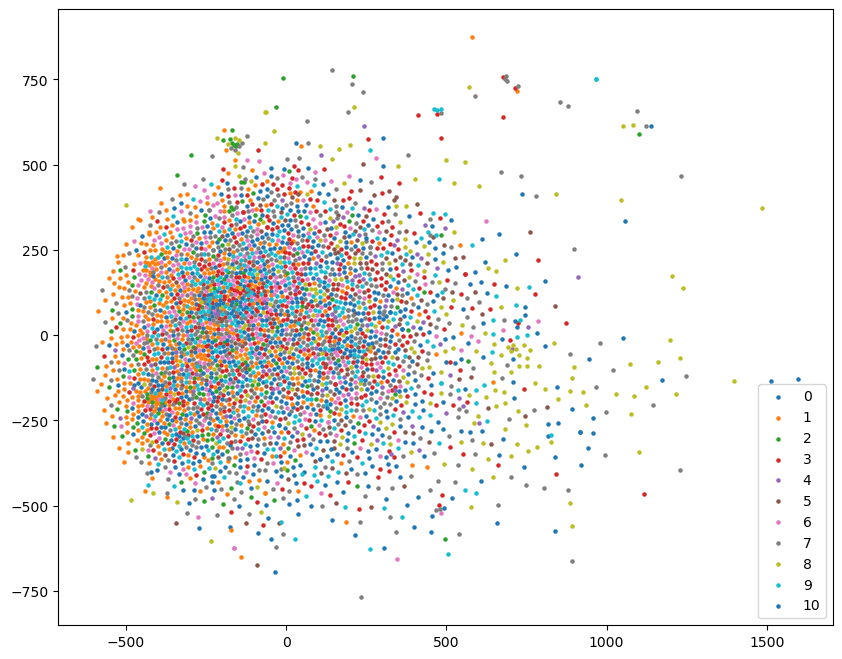

In [33]:
# Load the vaildation set defined by TA
valid_set = FoodDataset("./valid/", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
index = 5 # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.cnn[:index](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)
    
features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()